<a href="https://colab.research.google.com/github/Korniev/Data-Sciense/blob/main/hw_08/hw_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [25]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [26]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [27]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=None, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.activation:
            y = self.activation(y)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1, tf.nn.sigmoid)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, tf.nn.sigmoid)
        # Вихідний шар
        self.out_layer = DenseLayer(n_hidden_2, num_classes, tf.nn.softmax)

    def __call__(self, x):
        # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x)

        return x

In [28]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Визначаємо передбачений клас як індекс з найвищим значенням в передбаченнях
    predicted_class = tf.argmax(y_pred, axis=1)

    # Переконуємося, що y_true має тип int64 для сумісності з predicted_class
    y_true = tf.cast(y_true, tf.int64)

    # Порівнюємо передбачений клас з фактичним класом
    correct_prediction = tf.equal(predicted_class, y_true)
    # Обчислюємо точність
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [29]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [30]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())  # Додаємо поточну помилку до історії
        accuracy_history.append(acc.numpy())  # Додаємо поточну точність до історії
        print("Крок:", step, "Помилка:", loss.numpy(), "Точність:", acc.numpy())


Крок: 100 Помилка: 319.55072 Точність: 0.65625
Крок: 200 Помилка: 176.85358 Точність: 0.78515625
Крок: 300 Помилка: 188.97766 Точність: 0.78515625
Крок: 400 Помилка: 197.60577 Точність: 0.8046875
Крок: 500 Помилка: 114.31262 Точність: 0.85546875
Крок: 600 Помилка: 162.42395 Точність: 0.8203125
Крок: 700 Помилка: 89.26129 Точність: 0.8828125
Крок: 800 Помилка: 80.00957 Точність: 0.890625
Крок: 900 Помилка: 75.28225 Точність: 0.90625
Крок: 1000 Помилка: 90.50908 Точність: 0.87109375
Крок: 1100 Помилка: 120.041504 Точність: 0.87109375
Крок: 1200 Помилка: 71.40174 Точність: 0.90234375
Крок: 1300 Помилка: 108.92828 Точність: 0.875
Крок: 1400 Помилка: 95.40117 Точність: 0.90234375
Крок: 1500 Помилка: 63.284092 Точність: 0.92578125
Крок: 1600 Помилка: 93.657524 Точність: 0.90234375
Крок: 1700 Помилка: 87.809006 Точність: 0.90625
Крок: 1800 Помилка: 78.810745 Точність: 0.921875
Крок: 1900 Помилка: 48.576496 Точність: 0.94921875
Крок: 2000 Помилка: 72.396576 Точність: 0.92578125
Крок: 2100 Поми

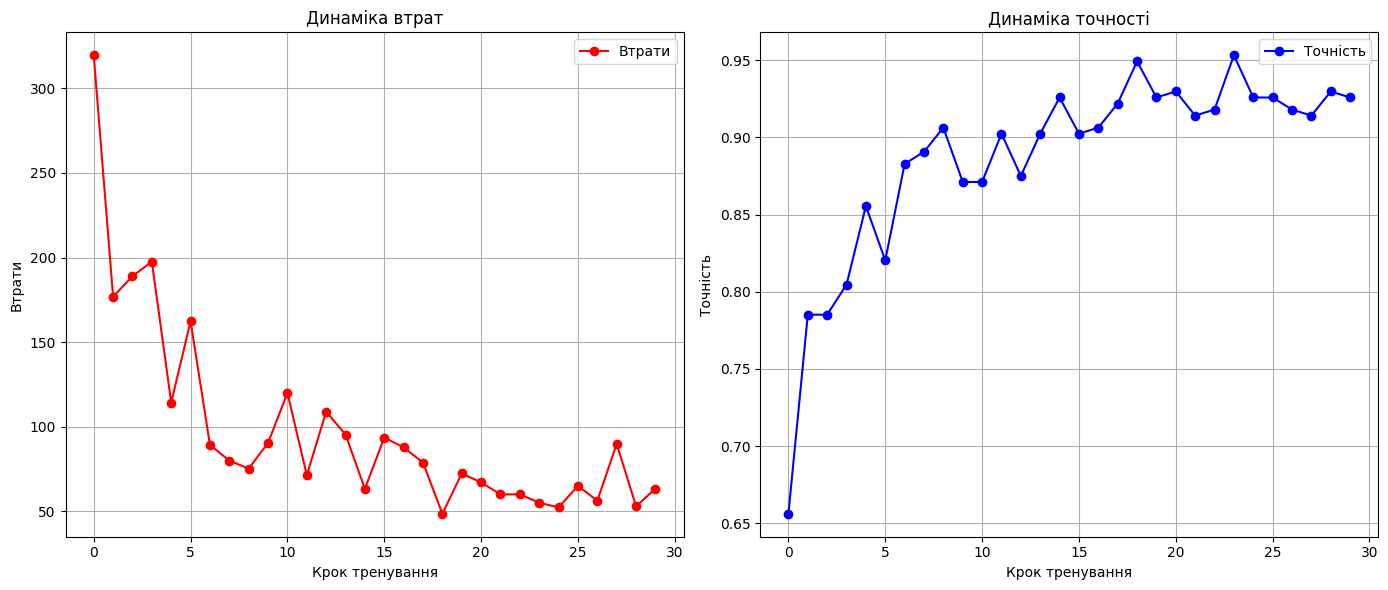

In [31]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_history, '-o', label='Втрати', color='red')
plt.title('Динаміка втрат')
plt.xlabel('Крок тренування')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, '-o', label='Точність', color='blue')
plt.title('Динаміка точності')
plt.xlabel('Крок тренування')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
# Передбачення на тестовому датасеті
predictions = neural_net(x_test)  # x_test - тестові дані
predicted_classes = tf.argmax(predictions, axis=1)

# Розрахунок точності
correct_predictions = tf.equal(predicted_classes, tf.cast(y_test, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

#Виведення результату точності
print(f"Точність на тестовому датасеті: {accuracy.numpy() * 100:.2f}%\n")

# Виведення метрик якості для кожного класу
print("Метрики якості по кожному класу:\n")
print(classification_report(y_test, predicted_classes.numpy()))

Точність на тестовому датасеті: 90.02%

Метрики якості по кожному класу:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.98      0.98      0.98      1135
           2       0.88      0.89      0.89      1032
           3       0.86      0.90      0.88      1010
           4       0.91      0.85      0.88       982
           5       0.85      0.89      0.87       892
           6       0.93      0.92      0.92       958
           7       0.95      0.87      0.91      1028
           8       0.90      0.84      0.87       974
           9       0.81      0.89      0.85      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



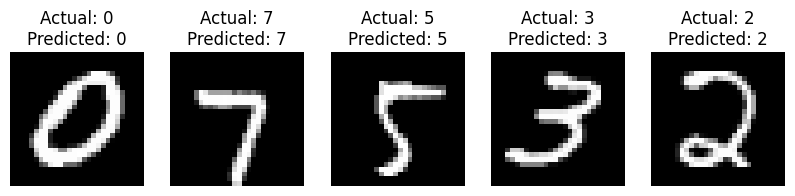

In [33]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
random_indices = np.random.choice(x_test.shape[0], 5)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

# Отримання передбачень від нейронної мережі
predictions = neural_net(random_images)
predicted_classes = tf.argmax(predictions, axis=1)

# Виведіть зображення та випишіть  поруч відповідь нейромережі.
plt.figure(figsize=(10, 5))
for i, (image, label, prediction) in enumerate(zip(random_images, random_labels, predicted_classes), start=1):
    plt.subplot(1, 5, i)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"Actual: {label}\nPredicted: {prediction.numpy()}")
    plt.axis('off')
plt.show()



## Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

Точність моєї нейронної мережі на тестовому датасеті скаладає 90%, що я вважаю дуже не поганим результатом.

Щодо тестування нейронної мережі, то ми рандомно вибрали 5 випадкових значень і передали їх у нейронну мережу.
Як результат, ми маємо 5 з 5. Що також супер, навіть при точності 90%.

Метрики якості для кожного класу такы як точність, повнота, f-score також мають показники більше 80, що є дуже не поганим результатом.